In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# replace <PATd:/spofrte/modeH-TO-SAVED-MODEL> with the real path of the saved model
model_path = 'bert-large-uncased-whole-word-masking-finetuned-squad'

# load model
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask, )
    return output.start_logits, output.end_logits

def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
                    [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)


def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)  # * -1
    return token_type_ids, ref_token_type_ids


def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids


def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)


def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=token_type_ids,
                                                 position_ids=position_ids)

    return input_embeddings, ref_input_embeddings
def predict_qt(question, text):

    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)

    ground_truth = '13'


    start_scores, end_scores = predict(input_ids, \
                                       token_type_ids=token_type_ids, \
                                       position_ids=position_ids, \
                                       attention_mask=attention_mask)


    print('Question: ', question)
    print('Predicted Answer: ', ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))
    return input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens, 

def explain(input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens, ):
    lig = LayerIntegratedGradients(squad_pos_forward_func, model.bert.embeddings)

    attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                                    baselines=ref_input_ids,
                                                    additional_forward_args=(
                                                    token_type_ids, position_ids, attention_mask, 0),
                                                    internal_batch_size=4,
                                                    return_convergence_delta=True)
    attributions_end, delta_end = lig.attribute(inputs=input_ids, baselines=ref_input_ids,
                                                additional_forward_args=(
                                                token_type_ids, position_ids, attention_mask, 1),
                                                internal_batch_size=4,
                                                return_convergence_delta=True)

    attributions_start_sum = summarize_attributions(attributions_start)
    attributions_end_sum = summarize_attributions(attributions_end)
    # storing couple samples in an array for visualization purposes
    start_position_vis = viz.VisualizationDataRecord(
        attributions_start_sum,
        torch.max(torch.softmax(start_scores[0], dim=0)),
        torch.argmax(start_scores),
        torch.argmax(start_scores),
        str(ground_truth),
        attributions_start_sum.sum(),
        all_tokens,
        delta_start)

    end_position_vis = viz.VisualizationDataRecord(
        attributions_end_sum,
        torch.max(torch.softmax(end_scores[0], dim=0)),
        torch.argmax(end_scores),
        torch.argmax(end_scores),
        str(ground_truth),
        attributions_end_sum.sum(),
        all_tokens,
        delta_end)
    print(all_tokens)
    print('\033[1m', 'Visualizations For Start Position', '\033[0m')
    viz.visualize_text([start_position_vis])

    print('\033[1m', 'Visualizations For End Position', '\033[0m')

    print("attributions_start_sum:   ", len(attributions_start_sum))
    print("all tokens:    ", len(all_tokens))
    
    print(torch.max(torch.softmax(end_scores[0], dim=0)), 
      torch.argmax(end_scores),
      torch.argmax(end_scores),
      torch.max(torch.softmax(start_scores[0], dim=0)))
    
    return all_tokens, attributions_start_sum

def get_posneg(all_tokens, attributions_start_sum):
    
    positive=[]
    negative=[]
    neutral = []
    for i,j in enumerate(attributions_start_sum):
        if j>0:
            positive.append(i)
            #print('positive:',j)
    ##print(all_tokens[i])
        elif j < 0:
            negative.append(i)
            #print('negative:',j)
            #print(all_tokens[i])
        elif j ==0:
            neutral.append(i)

    s_pos=''
    s_neg=''

    #print(len(attributions_start_sum))
    #print(len(positive))
    #print(len(negative))

    for i in positive:
        s_pos+=all_tokens[i]+' '
    print("positive :" , s_pos)
    for i in negative:
        s_neg+=all_tokens[i]+' '
    print("negative :" , s_neg)
    return positive, negative, neutral

def separate_sentence(all_tokens):
    sentence = {}
    temp = []
    num = 0
    for i in range(len(all_tokens)):
        if all_tokens[i] == "," or all_tokens[i] == ".":
            temp.append(all_tokens[i])
            sentence[num] = temp
            temp = []
            num = num +1
        elif all_tokens[i] == "[CLS]" :
            temp.append(all_tokens[i])
            sentence[num] = temp
            temp = []
            num = num +1
        elif all_tokens[i] == "[SEP]":
            sentence[num] = temp
            num = num +1
            temp = [all_tokens[i]]
            sentence[num] = temp
            temp = []
            num = num +1
        else:
            temp.append(all_tokens[i])
    return sentence  
def get_delete(sentence):
    weight = 0
    sum_weight = 0
    sentence_value=[]
    delete_sentence = []
    for k,v in sentence.items():
        #print(k,':',v)
        for i in v:
            sentence_value.append(i)
    print(sentence_value)
    scores={}
    #print(attributions_start_sum[0].item())

    for i in range(len(attributions_start_sum)):
        try:
            scores[sentence_value[i]]=attributions_start_sum[i].item()
        except:
            pass


    for i, j in sentence.items():
        sum_weight = 0
        for word in j:
            weight = 0

            sum_weight +=  scores[word]
        if sum_weight <= 0:
            delete_sentence.append(i)
    return delete_sentence

def delete_sentence(sentence, li_delete_sentence):
    for i, j in sentence.items():
        if i in li_delete_sentence:
            sentence[i] = []
        else:
            pass
    return sentence
def rebuild_sentence(ori_sentence):
    rebuild_str = ""
    for i, j in ori_sentence.items():
        for word in j:
            rebuild_str += word 
            rebuild_str += " "
    return rebuild_str
def pred_explain(question, text):
    input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth , all_tokens,  = predict_qt(question,text)

    all_tokens, attributions_start_sum = explain(input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens, )
    
    return all_tokens, attributions_start_sum

def show_detail(sentence):
    weight = 0
    sum_weight = 0
    sentence_value=[]
    delete_sentence = []
    for k,v in sentence.items():
        for i in v:
            sentence_value.append(i)
    scores={}


    for i in range(len(attributions_start_sum)):
        try:
            scores[sentence_value[i]]=attributions_start_sum[i].item()
        except:
            pass


    for i, j in sentence.items():
        sum_weight = 0
        for word in j:
            sum_weight +=  scores[word]
            
        print(sum_weight)
        if sum_weight <= 0:
            delete_sentence.append(i)
    return delete_sentence
def show_detail_average(sentence):
    weight = 0
    sum_weight = 0
    sentence_value=[]
    delete_sentence = []
    for k,v in sentence.items():
        for i in v:
            sentence_value.append(i)
    scores={}


    for i in range(len(attributions_start_sum)):
        try:
            scores[sentence_value[i]]=attributions_start_sum[i].item()
        except:
            pass


    for i, j in sentence.items():
        print(j)
        sum_weight = 0
        for word in j:
            sum_weight +=  scores[word]
        if len(j) != 0:
            
            print(sum_weight/len(j))
        if sum_weight <= 0:
            delete_sentence.append(i)
    return delete_sentence

In [57]:
question = "how old is guo zikun"
text= """ guozikun is 24 years old, he come from china, and a a master student in Kyungpook university."""

all_tokens, attributions_start_sum = pred_explain(question, text)

sentence = separate_sentence(all_tokens)
a  = show_detail_average(sentence)
sentence

Question:  how old is guo zikun
Predicted Answer:  24
['[CLS]', 'how', 'old', 'is', 'guo', 'z', '##ik', '##un', '[SEP]', 'guo', '##zi', '##ku', '##n', 'is', '24', 'years', 'old', ',', 'he', 'come', 'from', 'china', ',', 'and', 'a', 'a', 'master', 'student', 'in', 'ky', '##ung', '##poo', '##k', 'university', '.', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    36
all tokens:     36
tensor(0.5342, device='cuda:0', grad_fn=<MaxBackward1>) tensor(14, device='cuda:0') tensor(14, device='cuda:0') tensor(0.9929, device='cuda:0', grad_fn=<MaxBackward1>)
['[CLS]']
0.0
['how', 'old', 'is', 'guo', 'z', '##ik', '##un']
0.10314176531661011
['[SEP]']
0.0
['guo', '##zi', '##ku', '##n', 'is', '24', 'years', 'old', ',']
0.06453304158096912
['he', 'come', 'from', 'china', ',']
0.04971376406007235
['and', 'a', 'a', 'master', 'student', 'in', 'ky', '##ung', '##poo', '##k', 'university', '.']
0.023226390533461108
[]
['[SEP]']
0.0


{0: ['[CLS]'],
 1: ['how', 'old', 'is', 'guo', 'z', '##ik', '##un'],
 2: ['[SEP]'],
 3: ['guo', '##zi', '##ku', '##n', 'is', '24', 'years', 'old', ','],
 4: ['he', 'come', 'from', 'china', ','],
 5: ['and',
  'a',
  'a',
  'master',
  'student',
  'in',
  'ky',
  '##ung',
  '##poo',
  '##k',
  'university',
  '.'],
 6: [],
 7: ['[SEP]']}

In [41]:
question = "where does guo zikun come from"
text= """ guozikun is 24 years old, he come from china, and a a master student in Kyungpook university."""

all_tokens, attributions_start_sum = pred_explain(question, text)

sentence = separate_sentence(all_tokens)
a  = show_detail(sentence)
sentence


Question:  where does guo zikun come from
Predicted Answer:  china
['[CLS]', 'where', 'does', 'guo', 'z', '##ik', '##un', 'come', 'from', '[SEP]', 'guo', '##zi', '##ku', '##n', 'is', '24', 'years', 'old', ',', 'he', 'come', 'from', 'china', ',', 'and', 'a', 'a', 'master', 'student', 'in', 'ky', '##ung', '##poo', '##k', 'university', '.', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    37
all tokens:     37
tensor(0.9888, device='cuda:0', grad_fn=<MaxBackward1>) tensor(22, device='cuda:0') tensor(22, device='cuda:0') tensor(0.9758, device='cuda:0', grad_fn=<MaxBackward1>)
0.0
1.1748191780218022
0.0
1.156622085910836
0.4039348966167958
0.34225700577457147
0
0.0


{0: ['[CLS]'],
 1: ['where', 'does', 'guo', 'z', '##ik', '##un', 'come', 'from'],
 2: ['[SEP]'],
 3: ['guo', '##zi', '##ku', '##n', 'is', '24', 'years', 'old', ','],
 4: ['he', 'come', 'from', 'china', ','],
 5: ['and',
  'a',
  'a',
  'master',
  'student',
  'in',
  'ky',
  '##ung',
  '##poo',
  '##k',
  'university',
  '.'],
 6: [],
 7: ['[SEP]']}

In [42]:
question = "Where did Guo Zikun study for master?"
text= """My name is guo zikun, i am 24 years old, I come from china, and guo zikun is a a master student in Kyungpook university."""

all_tokens, attributions_start_sum = pred_explain(question, text)

sentence = separate_sentence(all_tokens)
a  = show_detail(sentence)
sentence

Question:  Where did Guo Zikun study for master?
Predicted Answer:  ky ##ung ##poo ##k university
['[CLS]', 'where', 'did', 'guo', 'z', '##ik', '##un', 'study', 'for', 'master', '?', '[SEP]', 'my', 'name', 'is', 'guo', 'z', '##ik', '##un', ',', 'i', 'am', '24', 'years', 'old', ',', 'i', 'come', 'from', 'china', ',', 'and', 'guo', 'z', '##ik', '##un', 'is', 'a', 'a', 'master', 'student', 'in', 'ky', '##ung', '##poo', '##k', 'university', '.', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    49
all tokens:     49
tensor(0.9541, device='cuda:0', grad_fn=<MaxBackward1>) tensor(46, device='cuda:0') tensor(46, device='cuda:0') tensor(0.9991, device='cuda:0', grad_fn=<MaxBackward1>)
0.0
1.7874101479958566
0.0
0.478144493452504
0.38249345449245165
0.43055224678018966
1.6342942406444603
0
0.0


{0: ['[CLS]'],
 1: ['where',
  'did',
  'guo',
  'z',
  '##ik',
  '##un',
  'study',
  'for',
  'master',
  '?'],
 2: ['[SEP]'],
 3: ['my', 'name', 'is', 'guo', 'z', '##ik', '##un', ','],
 4: ['i', 'am', '24', 'years', 'old', ','],
 5: ['i', 'come', 'from', 'china', ','],
 6: ['and',
  'guo',
  'z',
  '##ik',
  '##un',
  'is',
  'a',
  'a',
  'master',
  'student',
  'in',
  'ky',
  '##ung',
  '##poo',
  '##k',
  'university',
  '.'],
 7: [],
 8: ['[SEP]']}

Question:  where does guo zikun come from
Predicted Answer:  china
['[CLS]', 'where', 'does', 'guo', 'z', '##ik', '##un', 'come', 'from', '[SEP]', 'guo', '##zi', '##ku', '##n', 'is', '24', 'years', 'old', ',', 'he', 'comes', 'from', 'china', ',', '[SEP]']
 Visualizations For Start Position 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
22,22 (0.97),13,4.18,"[CLS] where does guo z ##ik ##un come from [SEP] guo ##zi ##ku ##n is 24 years old , he comes from china , [SEP]"


 Visualizations For End Position 
attributions_start_sum:    25
all tokens:     25
tensor(0.9855, device='cuda:0', grad_fn=<MaxBackward1>) tensor(22, device='cuda:0') tensor(22, device='cuda:0') tensor(0.9699, device='cuda:0', grad_fn=<MaxBackward1>)
['[CLS]']
0.0
['where', 'does', 'guo', 'z', '##ik', '##un', 'come', 'from']
0.2674341595725149
['[SEP]']
0.0
['guo', '##zi', '##ku', '##n', 'is', '24', 'years', 'old', ',']
0.15417210843901724
['he', 'comes', 'from', 'china', ',']
0.18077267531326838
[]
['[SEP]']
0.0


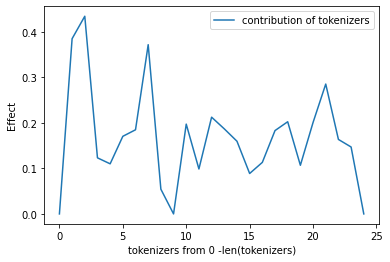

In [59]:
question = "where does guo zikun come from"
text= """ guozikun is 24 years old, he comes from china, """

all_tokens, attributions_start_sum = pred_explain(question, text)

sentence = separate_sentence(all_tokens)
a  = show_detail_average(sentence)
sentence
plt.plot(range(len(attributions_start_sum.cpu())), attributions_start_sum.cpu(), label = "contribution of tokenizers")
plt.xlabel("""tokenizers from 0 -len(tokenizers)""")
plt.ylabel('Effect')
plt.legend()
plt.show()

Question:  where does guo zikun come from
Predicted Answer:  china
['[CLS]', 'where', 'does', 'guo', 'z', '##ik', '##un', 'come', 'from', '[SEP]', 'guo', '##zi', '##ku', '##n', 'is', '24', 'years', 'old', ',', 'he', 'come', 'from', 'china', ',', 'guo', 'z', '##ik', '##un', 'likes', 'korean', 'and', 'like', 'chinese', 'and', 'have', 'good', 'friends', 'and', 'his', 'professor', 'is', 'a', 'cool', 'man', 'and', 'his', 'senior', 'is', 'a', 'handsome', 'man', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    52
all tokens:     52
tensor(0.9875, device='cuda:0', grad_fn=<MaxBackward1>) tensor(22, device='cuda:0') tensor(22, device='cuda:0') tensor(0.9814, device='cuda:0', grad_fn=<MaxBackward1>)
['[CLS]']
0.0
['where', 'does', 'guo', 'z', '##ik', '##un', 'come', 'from']
0.17149464868407144
['[SEP]']
0.0
['guo', '##zi', '##ku', '##n', 'is', '24', 'years', 'old', ',']
0.08156197663363869
['he', 'come', 'from', 'china', ',']
0.1284126832889562
['guo', 'z', '##ik', '##un', 'likes', 'korean', 'and', 'like', 'chinese', 'and', 'have', 'good', 'friends', 'and', 'his', 'professor', 'is', 'a', 'cool', 'man', 'and', 'his', 'senior', 'is', 'a', 'handsome', 'man']
0.07440999291129445
['[SEP]']
0.0


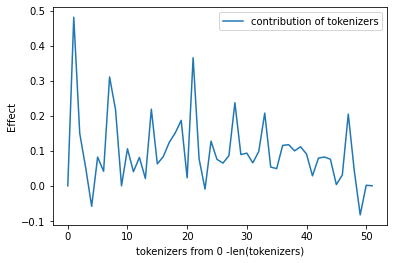

In [58]:
question = "where does guo zikun come from"
text= """ guozikun is 24 years old, he come from china, guo zikun likes korean and like chinese and have good friends and his professor is a cool man and his senior is a handsome man"""

all_tokens, attributions_start_sum = pred_explain(question, text)

sentence = separate_sentence(all_tokens)
a  = show_detail_average(sentence)
sentence

plt.plot(range(len(attributions_start_sum.cpu())), attributions_start_sum.cpu(), label = "contribution of tokenizers")
plt.xlabel("""tokenizers from 0 -len(tokenizers)""")
plt.ylabel('Effect')
plt.legend()
plt.show()
